In [288]:
import rasterio
import pandas as pd
from pyproj import Transformer
import glob
import numpy as np

In [290]:
import os
import ntpath
cwd = os.getcwd()
cwd

'C:\\Users\\nimbus\\PycharmProjects\\LandCover\\notebooks'

In [292]:
input_path = "data/landcover/*"

In [294]:
file_paths = glob.glob(input_path)
file_paths

['data/landcover\\B02_10m.tiff',
 'data/landcover\\B03_10m.tiff',
 'data/landcover\\B04_10m.tiff',
 'data/landcover\\B08_10m.tiff',
 'data/landcover\\B11_10m.tiff',
 'data/landcover\\B12_10m.tiff',
 'data/landcover\\ground_truth.tif',
 'data/landcover\\input_stack.tiff',
 'data/landcover\\NDBI.tiff',
 'data/landcover\\NDDI.tiff',
 'data/landcover\\NDUI.tiff',
 'data/landcover\\NDVI.tiff',
 'data/landcover\\NDWI.tiff']

In [296]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [298]:
def file_name_from_path(path):
    return path_leaf(path).split(".")[0]

In [316]:
for file_path in file_paths:
    print(file_name_from_path(file_path))

B02_10m
B03_10m
B04_10m
B08_10m
B11_10m
B12_10m
ground_truth
input_stack
NDBI
NDDI
NDUI
NDVI
NDWI


In [318]:
def get_data_frame(file_paths, latlon_crs = 'epsg:4326'):
    df_list = []
    for file_path in file_paths:
        with rasterio.open(file_path) as f:
            zz = f.read(1)
            x = np.linspace(f.bounds.left, f.bounds.right, f.shape[1])
            y = np.linspace(f.bounds.bottom, f.bounds.top, f.shape[0])
        xx, yy = np.meshgrid(x, y)
        df = pd.DataFrame({
            'x': xx.flatten(),
            'y': yy.flatten(),
            'value': zz.flatten(),
        })
        transformer = Transformer.from_crs(f.crs, latlon_crs, always_xy=False)
        df['lat'], df['lon'] = transformer.transform(xx=df.x, yy=df.y)
        df.drop(columns=['x', 'y'], inplace=True)
        df = df[['lat', 'lon', 'value']]
        file_name = file_name_from_path(file_path)
        df = df.rename(columns={"value": file_name})
        df_list.append(df)
    return df_list

In [320]:
df_list =  get_data_frame(file_paths, latlon_crs = 'epsg:4326')
df_list

[            lat        lon  B02_10m
 0     -8.990286  51.785690        0
 1     -8.988815  51.785690        0
 2     -8.987344  51.785690        0
 3     -8.985873  51.785690        0
 4     -8.984402  51.785690        0
 ...         ...        ...      ...
 13627 -8.788750  51.871608        0
 13628 -8.787279  51.871608        0
 13629 -8.785808  51.871608        0
 13630 -8.784337  51.871608        0
 13631 -8.782866  51.871608        0
 
 [13632 rows x 3 columns],
             lat        lon  B03_10m
 0     -8.990286  51.785690        0
 1     -8.988815  51.785690        0
 2     -8.987344  51.785690        0
 3     -8.985873  51.785690        0
 4     -8.984402  51.785690        0
 ...         ...        ...      ...
 13627 -8.788750  51.871608        0
 13628 -8.787279  51.871608        0
 13629 -8.785808  51.871608        0
 13630 -8.784337  51.871608        0
 13631 -8.782866  51.871608        0
 
 [13632 rows x 3 columns],
             lat        lon  B04_10m
 0     -8.990286 

In [322]:
len(df_list[1:])

12

In [324]:
result_df = df_list[0]
for df in df_list[1:]:
    result_df = pd.merge(result_df, df, how="left", on=["lat", "lon"])
result_df

,lat,lon,B02_10m,B03_10m,B04_10m,B08_10m,B11_10m,B12_10m,ground_truth,input_stack,NDBI,NDDI,NDUI,NDVI,NDWI
0,-8.990286,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0,0
1,-8.988815,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0,0
2,-8.987344,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0,0
3,-8.985873,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0,0
4,-8.984402,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13627,-8.788750,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0,0
13628,-8.787279,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0,0
13629,-8.785808,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0,0
13630,-8.784337,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0,0


In [326]:
result_df.drop(columns=['input_stack'], inplace=True)
result_df

,lat,lon,B02_10m,B03_10m,B04_10m,B08_10m,B11_10m,B12_10m,ground_truth,NDBI,NDDI,NDUI,NDVI,NDWI
0,-8.990286,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0
1,-8.988815,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0
2,-8.987344,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0
3,-8.985873,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0
4,-8.984402,51.785690,0,0,0,0,0,0,-128,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13627,-8.788750,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0
13628,-8.787279,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0
13629,-8.785808,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0
13630,-8.784337,51.871608,0,0,0,0,0,0,-128,0,0,0,0,0


In [328]:
result_df.shape

(13632, 14)

In [379]:
X = result_df[["B02_10m", "B03_10m", "B04_10m", "B08_10m", "B11_10m", "B12_10m", "NDBI", "NDDI", "NDUI", "NDVI", "NDWI"]]
X

,B02_10m,B03_10m,B04_10m,B08_10m,B11_10m,B12_10m,NDBI,NDDI,NDUI,NDVI,NDWI
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13627,0,0,0,0,0,0,0,0,0,0,0
13628,0,0,0,0,0,0,0,0,0,0,0
13629,0,0,0,0,0,0,0,0,0,0,0
13630,0,0,0,0,0,0,0,0,0,0,0


In [485]:
X = result_df[["lat", "lon", "B02_10m", "B03_10m", "B04_10m", "B08_10m", "B11_10m", "B12_10m", "NDBI", "NDDI", "NDUI", "NDVI", "NDWI"]]
X

,lat,lon,B02_10m,B03_10m,B04_10m,B08_10m,B11_10m,B12_10m,NDBI,NDDI,NDUI,NDVI,NDWI
0,-8.990286,51.785690,0,0,0,0,0,0,0,0,0,0,0
1,-8.988815,51.785690,0,0,0,0,0,0,0,0,0,0,0
2,-8.987344,51.785690,0,0,0,0,0,0,0,0,0,0,0
3,-8.985873,51.785690,0,0,0,0,0,0,0,0,0,0,0
4,-8.984402,51.785690,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13627,-8.788750,51.871608,0,0,0,0,0,0,0,0,0,0,0
13628,-8.787279,51.871608,0,0,0,0,0,0,0,0,0,0,0
13629,-8.785808,51.871608,0,0,0,0,0,0,0,0,0,0,0
13630,-8.784337,51.871608,0,0,0,0,0,0,0,0,0,0,0


In [519]:
csv_path = "../data/land_cover/crookstown/updated_labels1.csv"
df = pd.read_csv(csv_path, usecols=["lat","lon", "value", "CODE_18"])
df

,lat,lon,value,CODE_18
0,-8.990286,51.785690,-128,999
1,-8.988815,51.785690,-128,999
2,-8.987344,51.785690,-128,999
3,-8.985873,51.785690,-128,999
4,-8.984402,51.785690,-128,999
...,...,...,...,...
13627,-8.788750,51.871608,-128,999
13628,-8.787279,51.871608,-128,999
13629,-8.785808,51.871608,-128,999
13630,-8.784337,51.871608,-128,999


In [517]:
df.dtypes

lat        float64
lon        float64
value        int64
CODE_18      int64
dtype: object

In [489]:
y = df["CODE_18"]
y

0        999
1        999
2        999
3        999
4        999
        ... 
13627    999
13628    999
13629    999
13630    999
13631    999
Name: CODE_18, Length: 13632, dtype: int64

In [491]:
labels = np.unique(y)
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

The training data include 10 classes: [112 131 211 231 243 311 312 313 324 999]


In [493]:
print('X matrix is sized: {sz}'.format(sz=X.shape))
print('y array is sized: {sz}'.format(sz=y.shape))

X matrix is sized: (13632, 13)
y array is sized: (13632,)


In [495]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=10000, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [497]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 94.7256455399061%


In [499]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.44324517162554705
Band 2 importance: 0.3748461967981428
Band 3 importance: 0.03154550823043832
Band 4 importance: 0.02337285636971902
Band 5 importance: 0.028833183539030773
Band 6 importance: 0.022607119957310032
Band 7 importance: 0.02251271831971291
Band 8 importance: 0.023870435255722577
Band 9 importance: 0.0003797820701576681
Band 10 importance: 0.0
Band 11 importance: 0.0014260005118208756


In [501]:
import pandas as pd

df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict  112  131  211   231  243  311  312  313  324   999    All
truth                                                             
112        3    0    0     0    0    0    0    0    0     0      3
131        0   61    0     0    0    0    0    0    0     0     61
211        0    0   25     0    0    0    0    0    0     0     25
231        0    0    0  6142    0    0    0    0    0     0   6142
243        0    0    0     0  294    0    0    0    0     0    294
311        0    0    0     0    0   22    0    0    0     0     22
312        0    0    0     0    0    0  223    0    0     0    223
313        0    0    0     0    0    0    0   28    0     0     28
324        0    0    0     0    0    0    0    0  123     0    123
999        0    0    0     0    0    0    0    0    0  6711   6711
All        3   61   25  6142  294   22  223   28  123  6711  13632


In [503]:
class_prediction = rf.predict(X)
class_prediction = class_prediction.reshape((96, 142))
class_prediction.shape

(96, 142)

In [505]:
class_prediction[0][0]

999

In [507]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import rasterio.plot

In [509]:
def load_cmap(file_path = "data/color_map.json"):
    # Color map is https://collections.sentinel-hub.com/corine-land-cover/readme.html
    lc = json.load(open(file_path))
    lc_df = pd.DataFrame(lc)
    # lc_df["palette"] = "#" + lc_df["palette"]
    values = lc_df["values"].to_list()
    palette = lc_df["palette"].to_list()
    labels = lc_df["label"].to_list()

    # Create colormap from values and palette
    cmap = ListedColormap(palette)

    # Patches legend
    patches = [
        mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
    ]
    legend = {
        "handles": patches,
        "bbox_to_anchor": (1.05, 1),
        "loc": 2,
        "borderaxespad": 0.0,
    }
    return cmap, legend

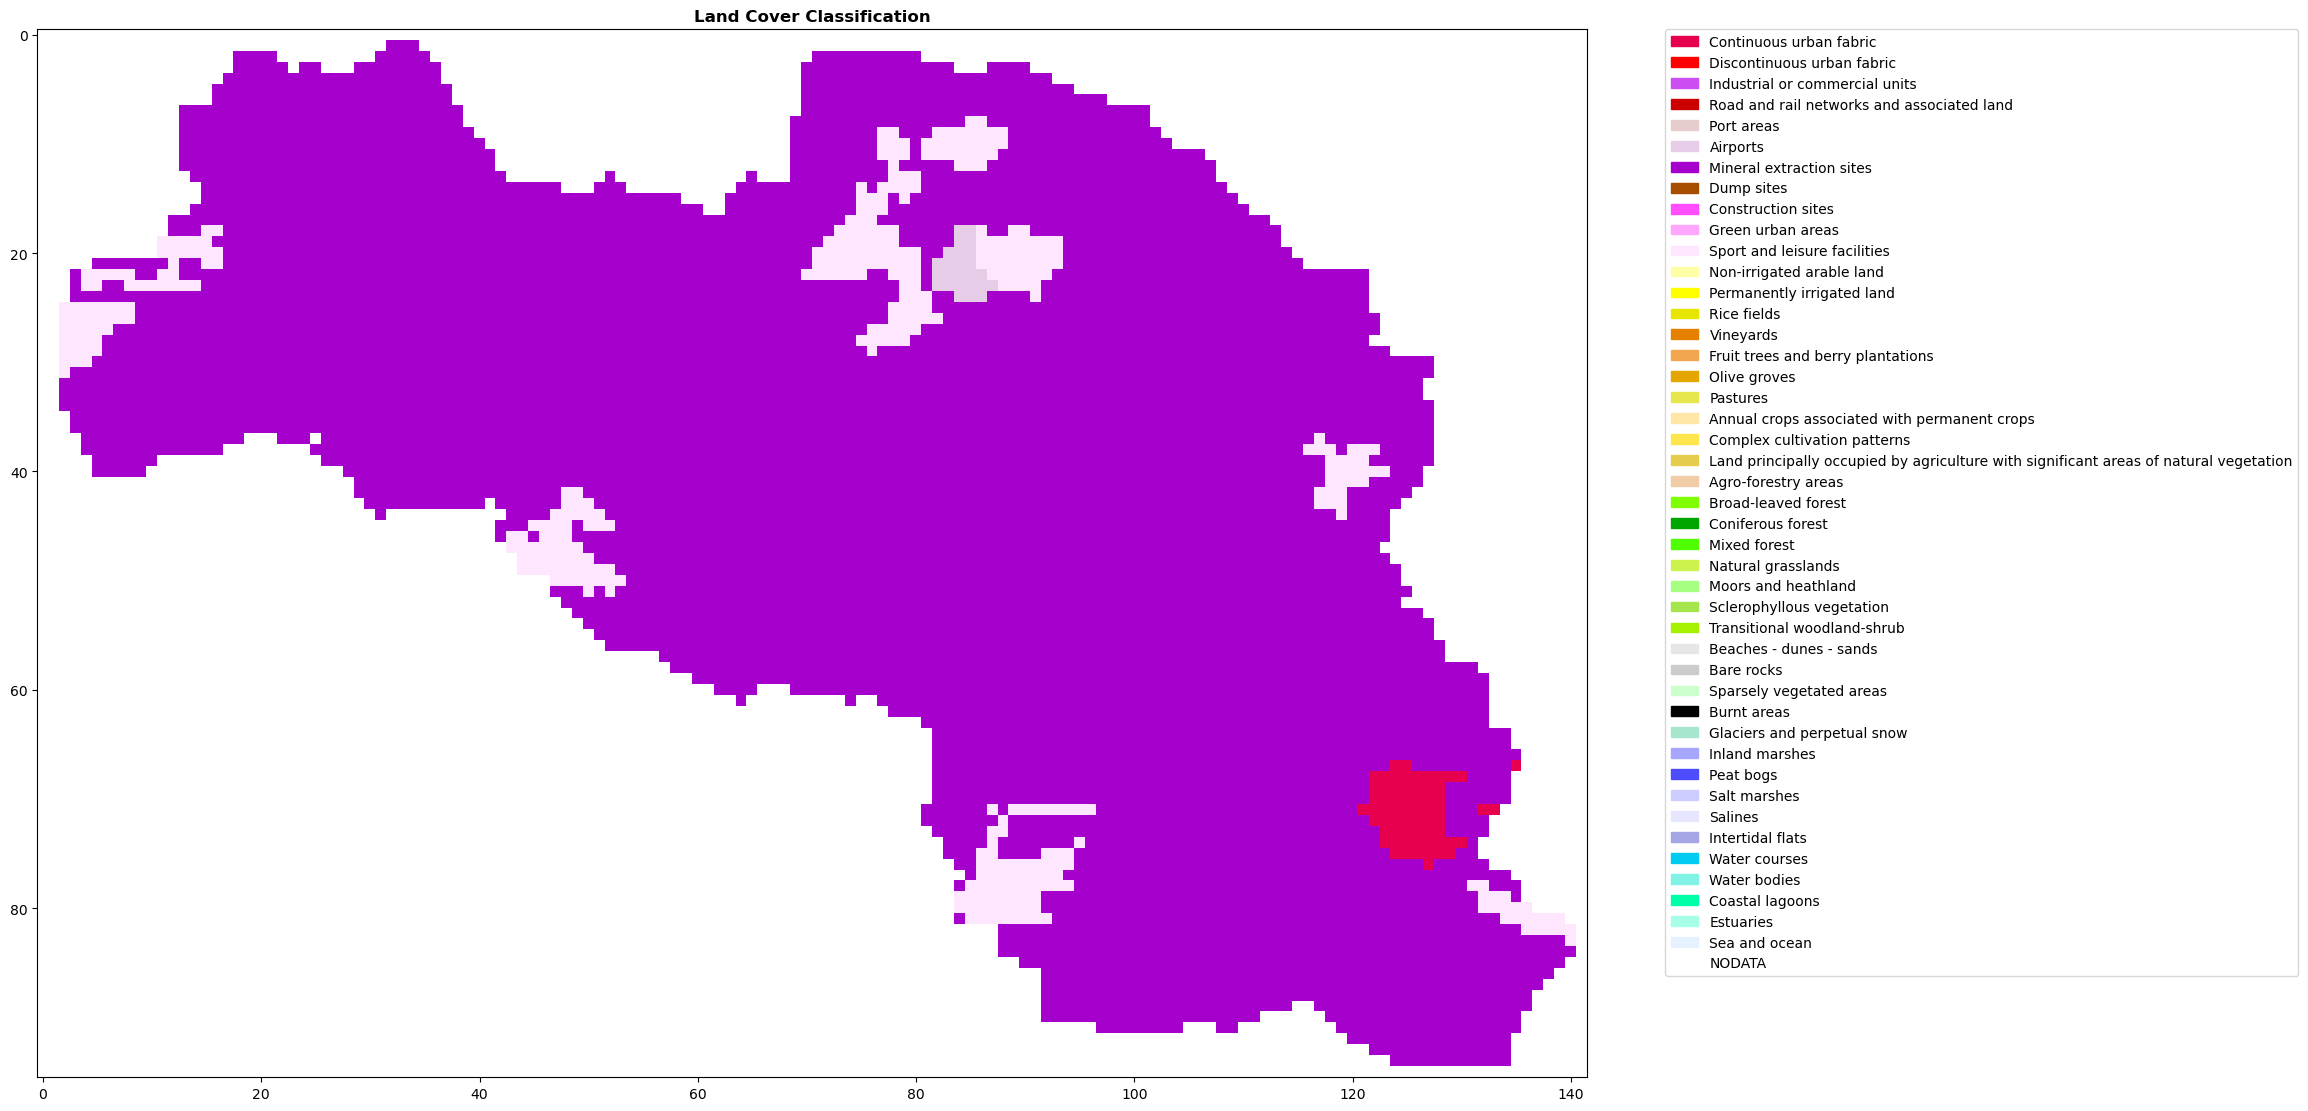

In [513]:
cmap, legend = load_cmap(file_path = "data/color_map.json")
fig, ax = plt.subplots(figsize=(20, 20))
ax.legend(**legend)
rasterio.plot.show(class_prediction, ax=ax, cmap=cmap, title='Land Cover Classification')
plt.show()

In [377]:
# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

(96, 142)

In [186]:
def ground_truth(file_path, latlon_crs = 'epsg:4326'):
    with rasterio.open(file_path) as f:
        zz = f.read(1)
        x = np.linspace(f.bounds.left, f.bounds.right, f.shape[1])
        y = np.linspace(f.bounds.bottom, f.bounds.top, f.shape[0])
        xx, yy = np.meshgrid(x, y)
        df = pd.DataFrame({
            'x': xx.flatten(),
            'y': yy.flatten(),
            'value': zz.flatten(),
        })
        transformer = Transformer.from_crs(f.crs, latlon_crs, always_xy=False)
        df['lat'], df['lon'] = transformer.transform(xx=df.x, yy=df.y)
        df.drop(columns=['x', 'y'], inplace=True)
        df = df[['lat', 'lon', 'value']]
        file_name = file_name_from_path(file_path)
        df = df.rename(columns={"value": file_name})
        return df

In [192]:
result_df = pd.concat(df_list).fillna(0.0)
result_df

,lat,lon,B02_10m,B03_10m,B04_10m,B08_10m,B11_10m,B12_10m,NDBI,NDDI,NDUI,NDVI,NDWI
0,-8.990286,51.785690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8.988815,51.785690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-8.987344,51.785690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-8.985873,51.785690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-8.984402,51.785690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13627,-8.788750,51.871608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13628,-8.787279,51.871608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13629,-8.785808,51.871608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13630,-8.784337,51.871608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
ground_truth_df = ground_truth("data/landcover\\ground_truth.tif")
ground_truth_df

,lat,lon,ground_truth
0,-8.990286,51.785690,-128
1,-8.988815,51.785690,-128
2,-8.987344,51.785690,-128
3,-8.985873,51.785690,-128
4,-8.984402,51.785690,-128
...,...,...,...
13627,-8.788750,51.871608,-128
13628,-8.787279,51.871608,-128
13629,-8.785808,51.871608,-128
13630,-8.784337,51.871608,-128


In [190]:
ground_truth_df.shape

(13632, 3)

In [244]:
result_df.describe()

,lat,lon,B02_10m,B03_10m,B04_10m,B08_10m,B11_10m,B12_10m,ground_truth,NDBI,NDDI,NDUI,NDVI,NDWI
count,13632.000000,13632.000000,13632.000000,13632.000000,13632.000000,13632.000000,13632.000000,13632.000000,13632.000000,13632.000000,13632.0,13632.000000,13632.000000,13632.000000
mean,-8.886576,51.828649,18.251907,3.863630,11.204372,0.352113,0.311033,4.297755,-52.345511,0.007336,0.0,0.009830,0.006089,4.813820
std,0.060303,0.025063,52.580926,56.184306,47.798961,54.538419,54.644746,55.303016,73.196193,0.250781,0.0,0.262419,0.221455,5.260714
min,-8.990286,51.785690,-128.000000,-128.000000,-128.000000,-128.000000,-128.000000,-128.000000,-128.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-8.938799,51.807170,0.000000,0.000000,0.000000,-10.000000,-10.000000,0.000000,-128.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,-8.886576,51.828649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,-8.834353,51.850129,57.000000,27.000000,35.000000,14.000000,13.250000,27.000000,18.000000,0.000000,0.0,0.000000,0.000000,10.000000
max,-8.782866,51.871608,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,29.000000,13.000000,0.0,16.000000,17.000000,22.000000


In [246]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13632 entries, 0 to 13631
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lat           13632 non-null  float64
 1   lon           13632 non-null  float64
 2   B02_10m       13632 non-null  int8   
 3   B03_10m       13632 non-null  int8   
 4   B04_10m       13632 non-null  int8   
 5   B08_10m       13632 non-null  int8   
 6   B11_10m       13632 non-null  int8   
 7   B12_10m       13632 non-null  int8   
 8   ground_truth  13632 non-null  int8   
 9   NDBI          13632 non-null  int8   
 10  NDDI          13632 non-null  int8   
 11  NDUI          13632 non-null  int8   
 12  NDVI          13632 non-null  int8   
 13  NDWI          13632 non-null  int8   
dtypes: float64(2), int8(12)
memory usage: 372.9 KB


In [248]:
# Putting feature variable to X
X = result_df.drop('ground_truth',axis=1)
# Putting response variable to y
y = result_df['ground_truth']

In [250]:
X.shape

(13632, 13)

In [252]:
y.shape

(13632,)

In [254]:
# now lets split the data into train and test
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((9542, 13), (4090, 13))

In [256]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

%%time
classifier_rf.fit(X_train, y_train)
# checking the oob score
classifier_rf.oob_score_

UsageError: Line magic function `%%time` not found.


In [258]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()